# Putting it all together : photonic systems

In this notebook, we will :

    1) Use zeropdk to create GDS geometries;
    2) Use parallel MEEP to visualize them and efficiently simulate their S-parameters to obtain compact models;
    3) Network many of these components together to overall circuit behaviour with Photontorch
    
In particular, we will simulate a multiring filter. Because FDTD simulations of resonant structures take a long time, we will model the rings as networks of bends :

!['multirings'](images/multirings.png)

Also, we will take very tight rings (bend radius of a few microns), which will require us to actually model the bends instead of simply using a "straight" waveguide for the rings.

# Defining geometries

From the block diagram, there are three topologies we will need to model :

    1) Quarter ring bends (2-port network)
    2) Straight-bend coupling (4-port network)
    3) Bend-bend coupling (4-port network)
    
The straight waveguides will simply be modeled as lossless phase accumulation.

## Layer definition

I define some layers :

In [27]:
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE1 = pya.LayerInfo(10, 0)
MEEP_SOURCE2 = pya.LayerInfo(11, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)
MEEP_PORT3 = pya.LayerInfo(22, 0)
MEEP_PORT4 = pya.LayerInfo(23, 0)

## Quarter ring bends

### Definition

In [28]:
import pya
import numpy as np

ring_radius = 5 # um
ring_width = 0.5 # um

In [66]:
from zeropdk.layout import layout_arc, layout_waveguide

layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

# draw bend
layout_arc(
    TOP, Si, origin - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2
)
# Extend the bend to avoid discontinuities
layout_waveguide(TOP, Si, [origin, origin - ring_radius*ex], ring_width)
layout_waveguide(TOP, Si, [origin - ring_radius*ey + ring_radius*ex, origin - 2*ring_radius*ey + ring_radius*ex], ring_width)

layout.write('bend_zeropdk.gds')
del layout, TOP

### Visualization

You could download the GDSII file from the cluster (see Files in MyAdroit dashboard), or just import the GDS with MEEP to look at it :

In [67]:
import meep as mp

In [68]:
silicon=mp.Medium(epsilon=12)
oxide=mp.Medium(epsilon=2.25)

res = 50        # pixels/μm
dpml = 2

In [69]:
gdsII_file = 'bend_zeropdk.gds'

CELL_LAYER = 0
Si_LAYER = 1

Si_bend = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER)

cell = mp.Vector3(2*ring_radius,2*ring_radius,0)
for geometry in Si_bend:
    geometry += mp.Vector3(-1*ring_radius/2,1*ring_radius/2,0)

In [70]:
sim = mp.Simulation(resolution=res,
                    eps_averaging=True,
                    subpixel_maxeval=1,
                    subpixel_tol=1,
                    boundary_layers=[mp.PML(dpml)],
                    geometry=Si_bend,
                    cell_size=cell)
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000329971 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
     prism, center = (0.664144,0.664152,0)
          height 0, axis (0,0,1), 132 vertices:
          (2.25,-2.5,0)
          (2.249,-2.383,0)
          (2.244,-2.267,0)
          (2.237,-2.151,0)
          (2.227,-2.034,0)
          (2.214,-1.919,0)
          (2.199,-1.803,0)
          (2.18,-1.688,0)
          (2.159,-1.573,0)
          (2.135,-1.459,0)
          (2.108,-1.346,0)
          (2.078,-1.233,0)
          (2.045,-1.121,0)
          (2.01,-1.01,0)
          (1.972,-0.9,0)
          (1.932,-0.791,0)
          (1.888,-0.682,0)
          (1.842,-0.575,0)
          (1.794,-0.469,0)
          (1.743,-0.364,0)
          (1.689,-0.261,0)
          (1.633,-0.159,0)
          (1.574,-0.058,0)
          (1.513,0.041,0)
          (1.449,0.139,0)
          (1.384,0.235,0)
          (1.315,0.33,0)
          (1.245,0.422,0)
    

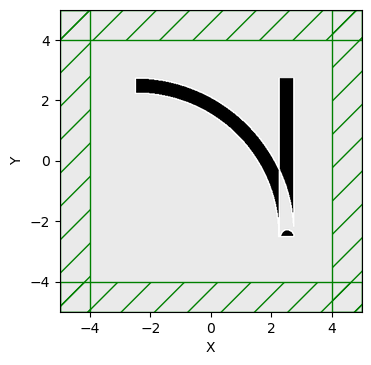

In [71]:
import matplotlib.pyplot as plt

f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()